In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [11]:
actions = [
    'ice',
    'hot',
    'americano',
    'card'
]

data = np.concatenate([
    np.load('./dataset/seq_ice_1713258658.npy'),
    np.load('./dataset/seq_hot_1713258658.npy'),
    np.load('./dataset/seq_americano_1713258658.npy'),
    np.load('./dataset/seq_card_1713258658.npy')
], axis=0)

data.shape

(3657, 30, 100)

In [7]:
actions = [
    'ice',
    'hot',
    'americano',
    'wc',
    'card'
]

data = np.concatenate([
    np.load('./dataset/seq_ice.npy'),
    np.load('./dataset/seq_hot.npy'),
    np.load('./dataset/seq_americano.npy'),
    np.load('./dataset/seq_wc.npy'),
    np.load('./dataset/seq_card.npy')
], axis=0)

data.shape

(5402, 30, 100)

In [8]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(5402, 30, 99)
(5402,)


In [9]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
# y_data = to_categorical(labels, num_classes=5)
y_data.shape

(5402, 5)

In [10]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(4861, 30, 99) (4861, 5)
(541, 30, 99) (541, 5)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 44,229
Trainable params: 44,229
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=90,
    callbacks=[
        ModelCheckpoint('models/model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/90
149/152 [============================>.] - ETA: 0s - loss: 22.8460 - acc: 0.4622
Epoch 1: val_acc improved from -inf to 0.71534, saving model to models\model.keras
152/152 [==============================] - 3s 12ms/step - loss: 22.4863 - acc: 0.4668 - val_loss: 4.8976 - val_acc: 0.7153 - lr: 0.0010
Epoch 2/90
148/152 [============================>.] - ETA: 0s - loss: 4.3525 - acc: 0.7722
Epoch 2: val_acc improved from 0.71534 to 0.82070, saving model to models\model.keras
152/152 [==============================] - 1s 10ms/step - loss: 4.2738 - acc: 0.7737 - val_loss: 1.7494 - val_acc: 0.8207 - lr: 0.0010
Epoch 3/90
151/152 [============================>.] - ETA: 0s - loss: 1.1409 - acc: 0.8851
Epoch 3: val_acc improved from 0.82070 to 0.94640, saving model to models\model.keras
152/152 [==============================] - 1s 10ms/step - loss: 1.1345 - acc: 0.8856 - val_loss: 0.1852 - val_acc: 0.9464 - lr: 0.0010
Epoch 4/90
149/152 [============================>.] - ETA: 0s - l

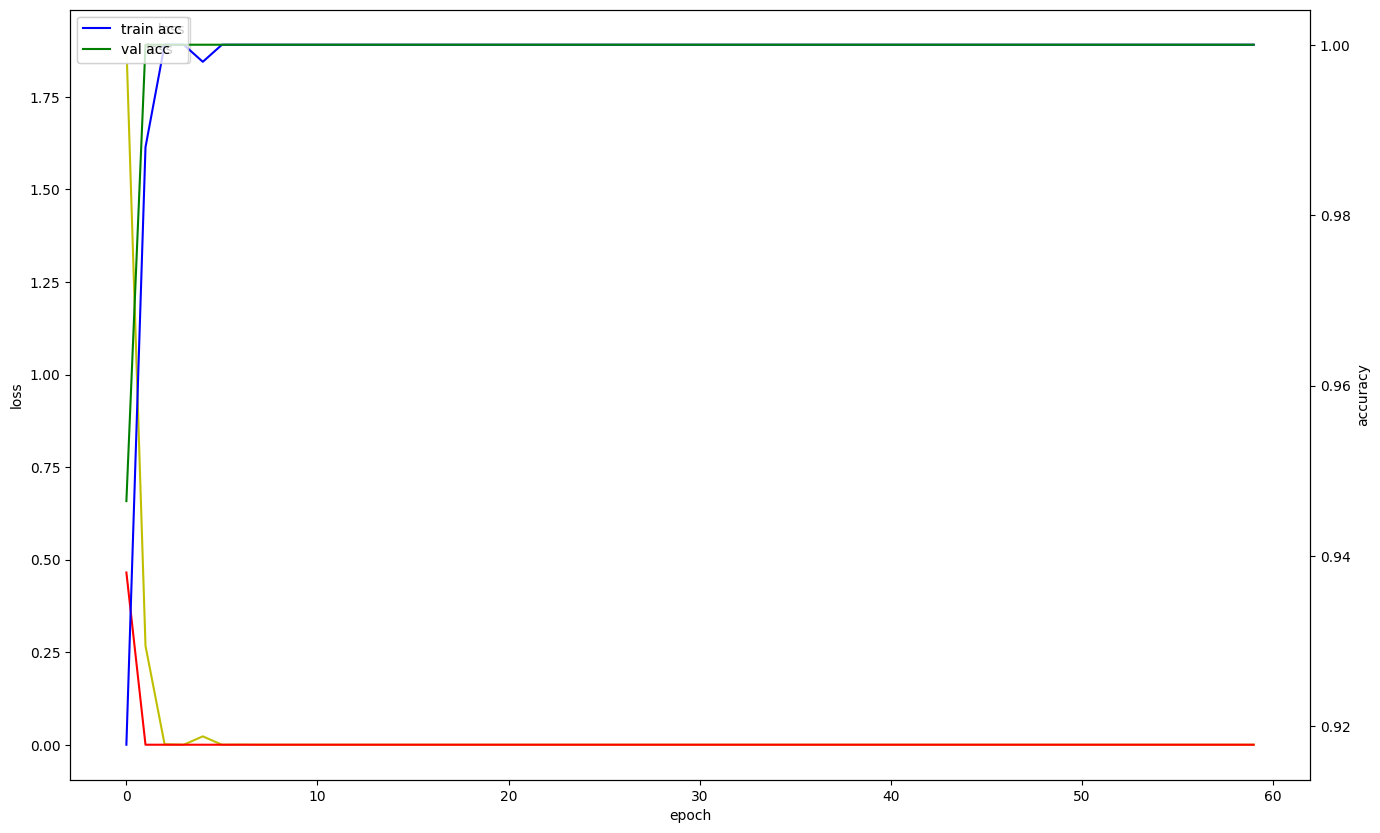

In [16]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [17]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.keras')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

2/2 [==============================] - 0s 0s/step


array([[[ 0,  0],
        [ 0, 56]]], dtype=int64)